# Batch Reactor Example
## Ignition delay computation

In this example we will illustrate how to setup and use a constant volume batch reactor. This reactor will then be used to compute the ignition delay of a gas at any temperature and pressure

The reactor (system) is simply an insulated box.

In [1]:
import pandas as pd
import numpy as np

import time

import cantera as ct
print('Runnning Cantera version: ' + ct.__version__)

Runnning Cantera version: 2.4.0


### Import modules and set plotting defaults

In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt

plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.autolayout'] = True

plt.style.use('ggplot')
plt.style.use('seaborn-pastel')

### Define the gas

In [17]:
marinov_species = ct.Species.listFromFile('marinov_ethanol_mechanism.cti')
marinov_reactions = ct.Reaction.listFromFile('marinov_ethanol_mechanism.cti')

gri_species = ct.Species.listFromFile('gri30.xml')
n_species = []
gri_reactions = ct.Reaction.listFromFile('gri30.xml')
n_reactions = []

# Filter species
for S in gri_species:
    comp = S.composition
    if 'N' in comp and comp != {'N':2}:
        # Include all nitrogen compounds except for N2
        n_species.append(S)
    if 'C' == S.name:
        # Include all nitrogen compounds except for N2
        n_species.append(S)

n_species_names = {S.name for S in n_species}
print('N based species: {0}'.format(', '.join(S.name for S in n_species)))

complete_species = marinov_species + n_species
complete_species_names = {S.name.upper() for S in complete_species}


# Filter reactions, keeping only those that only involve the selected species
print('\nReactions:')
for R in gri_reactions:
    if any(reactant in n_species_names for reactant in R.reactants) or any(product in n_species_names for product in R.products):
        for reactant in R.reactants:
            if reactant not in complete_species_names:
                print('Missing reactant:', reactant, 'when analyzing reaction', R.equation)
        for product in R.products:
            if product not in complete_species_names:
                print('Missing product:', product, 'when analyzing reaction', R.equation)
        if all(reactant in complete_species_names for reactant in R.reactants):
            if all(product in complete_species_names for product in R.products):
                n_reactions.append(R)
                print('Accepted reaction:', R.equation)
print('\n')

complete_species = marinov_species + n_species
complete_reactions = marinov_reactions + n_reactions

gas = ct.Solution(
    thermo='IdealGas',
    kinetics='GasKinetics',
    species=complete_species,
    reactions=complete_reactions
)

AttributeError: attribute 'name' of 'cantera._cantera.Species' objects is not writable

### Define reactor conditions : temperature, pressure, fuel, stoichiometry

In [5]:
# Define the reactor temperature and pressure
reactorTemperature = 1200 #Kelvin
reactorPressure = 101325.0 #Pascals

gas.TP = reactorTemperature, reactorPressure

# Define the fuel, oxidizer and set the stoichiometry
# gas.set_equivalence_ratio(phi=0.9, fuel={'c2h5oh':1.0, 'h2o':0.0}, oxidizer={'o2':1.0, 'n2':3.76})
gas.set_equivalence_ratio(phi=0.9, fuel={'c2h5oh':1.0, 'h2o':0.0}, oxidizer={'N2O':1.0})

# Create a batch reactor object and add it to a reactor network
# In this example, the batch reactor will be the only reactor
# in the network
r = ct.IdealGasReactor(contents=gas, name='Batch Reactor')
reactorNetwork = ct.ReactorNet([r])

# now compile a list of all variables for which we will store data
stateVariableNames = [r.component_name(item) for item in range(r.n_vars)]

# use the above list to create a DataFrame
timeHistory = pd.DataFrame(columns=stateVariableNames)

### Define useful functions

In [6]:
def ignitionDelay(df, species):
    """
    This function computes the ignition delay from the occurence of the
    peak in species' concentration.
    """
    return df[species].idxmax()

In [7]:
#Tic
t0 = time.time()

# This is a starting estimate. If you do not get an ignition within this time, increase it
estimatedIgnitionDelayTime = 10.0
t = 0

counter = 1;
while(t < estimatedIgnitionDelayTime):
    t = reactorNetwork.step()
    if (counter%10 == 0):
        # We will save only every 10th value. Otherwise, this takes too long
        # Note that the species concentrations are mass fractions
        timeHistory.loc[t] = reactorNetwork.get_state()
    counter+=1

# We will use the 'oh' species to compute the ignition delay
tau = ignitionDelay(timeHistory, 'co')

#Toc
t1 = time.time()

print('Computed Ignition Delay: {:.3e} seconds. Took {:3.2f}s to compute'.format(tau, t1-t0))

# If you want to save all the data - molefractions, temperature, pressure, etc
# uncomment the next line
# timeHistory.to_csv("time_history.csv")

Computed Ignition Delay: 7.749e-03 seconds. Took 1.07s to compute


## Plot the result

### Figure illustrating the definition of ignition delay

<IPython.core.display.Javascript object>


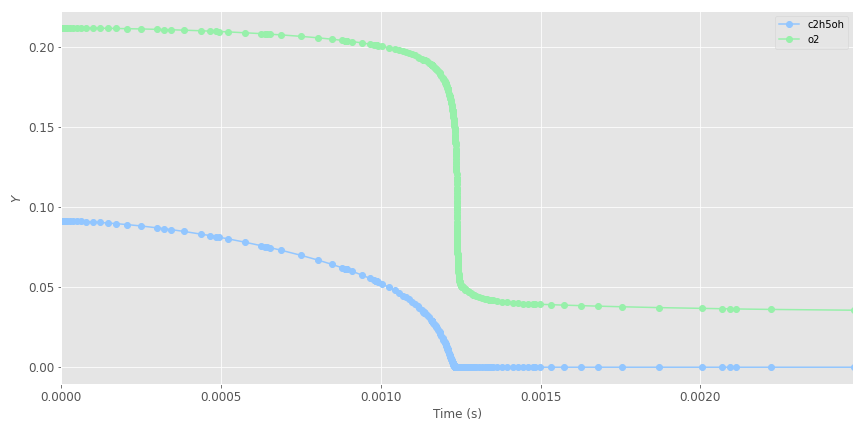

<IPython.core.display.Javascript object>


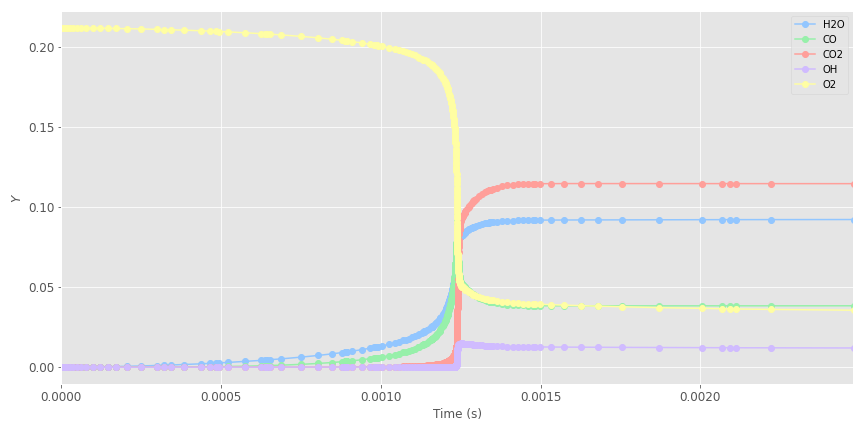

[]

In [202]:
plt.figure(figsize=(12,6))
plt.plot(timeHistory.index, timeHistory['c2h5oh'],'-o', label='c2h5oh')
plt.plot(timeHistory.index, timeHistory['o2'],'-o', label='o2')
# plt.plot(timeHistory.index, timeHistory['n2'],'-o', label='N2')
plt.xlabel('Time (s)')
plt.ylabel('$Y$')
plt.xlim([0,2*tau])
plt.legend()
plt.plot()

plt.figure(figsize=(12,6))
# plt.plot(timeHistory.index, timeHistory['n2'],'-o', label='n2')
plt.plot(timeHistory.index, timeHistory['h2o'],'-o', label='H2O')
plt.plot(timeHistory.index, timeHistory['co'],'-o', label='CO')
plt.plot(timeHistory.index, timeHistory['co2'],'-o', label='CO2')
plt.plot(timeHistory.index, timeHistory['oh'],'-o', label='OH')
plt.plot(timeHistory.index, timeHistory['o2'],'-o', label='O2')
# plt.plot(timeHistory.index, timeHistory['h2'],'-o', label='H2')
# plt.plot(timeHistory.index, timeHistory['NO'],'-o', label='NO')
plt.xlabel('Time (s)')
plt.ylabel('$Y$')
plt.xlim([0,2*tau])
plt.legend()
plt.plot()

<IPython.core.display.Javascript object>


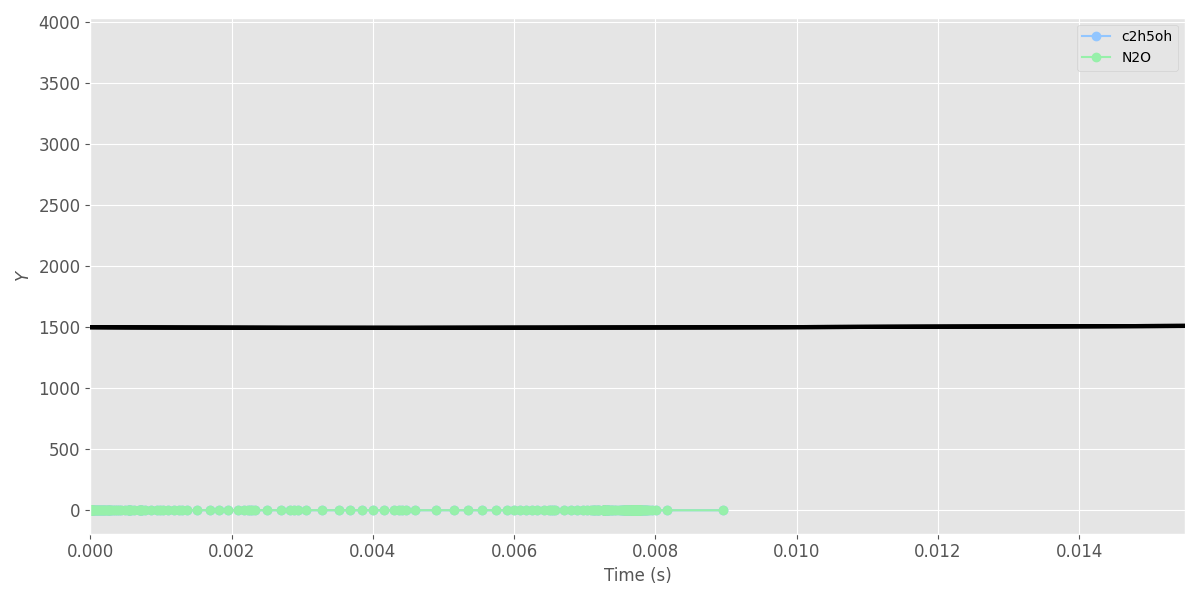

<IPython.core.display.Javascript object>


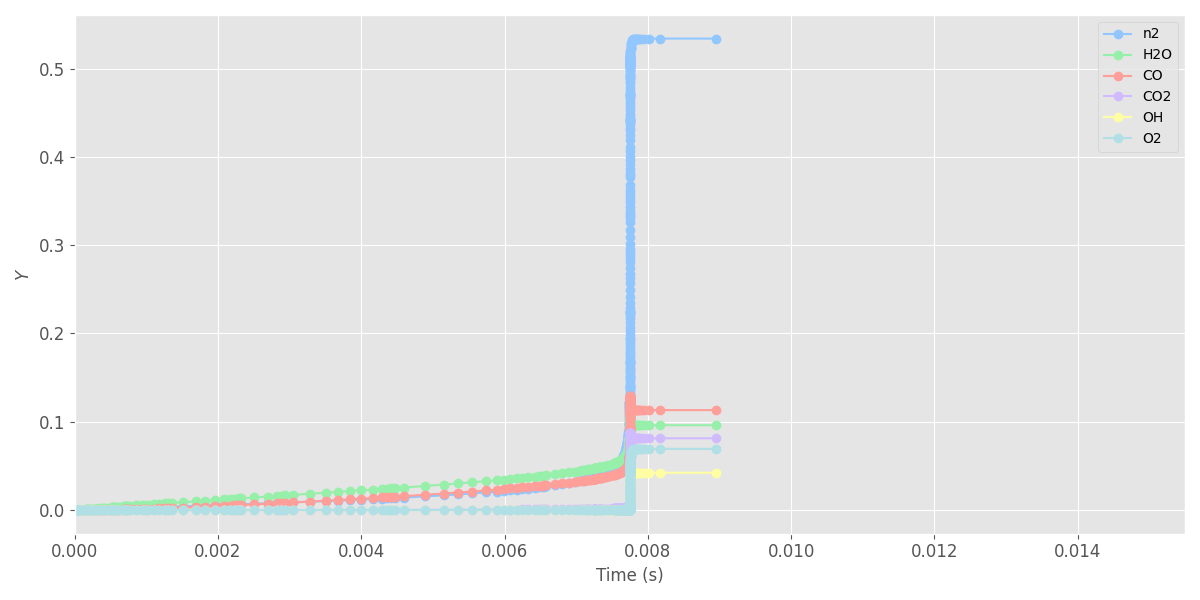

[]

In [8]:
plt.figure(figsize=(12,6))
plt.plot(timeHistory.index, timeHistory['c2h5oh'],'-o', label='c2h5oh')
plt.plot(timeHistory.index, timeHistory['N2O'],'-o', label='N2O')
plt.xlabel('Time (s)')
plt.ylabel('$Y$')
plt.xlim([0,2*tau])
plt.legend()
plt.plot()

plt.figure(figsize=(12,6))
plt.plot(timeHistory.index, timeHistory['n2'],'-o', label='n2')
plt.plot(timeHistory.index, timeHistory['h2o'],'-o', label='H2O')
plt.plot(timeHistory.index, timeHistory['co'],'-o', label='CO')
plt.plot(timeHistory.index, timeHistory['co2'],'-o', label='CO2')
plt.plot(timeHistory.index, timeHistory['oh'],'-o', label='OH')
plt.plot(timeHistory.index, timeHistory['o2'],'-o', label='O2')
# plt.plot(timeHistory.index, timeHistory['h2'],'-o', label='H2')
# plt.plot(timeHistory.index, timeHistory['NO'],'-o', label='NO')
plt.xlabel('Time (s)')
plt.ylabel('$Y$')
plt.xlim([0,2*tau])
plt.legend()
plt.plot()

<IPython.core.display.Javascript object>


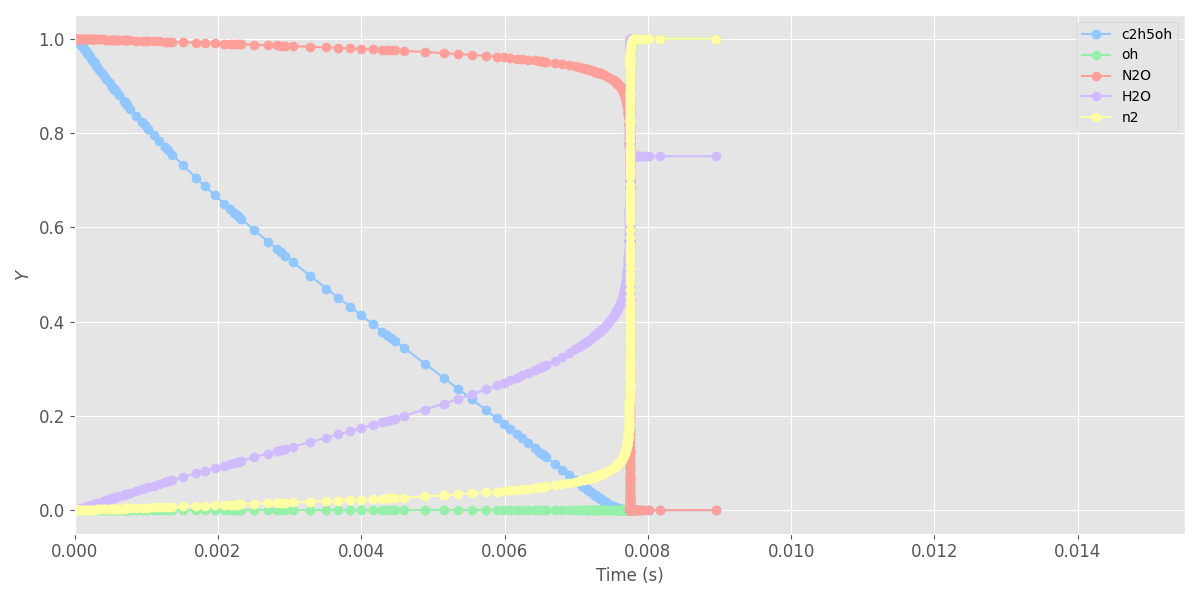

[]

In [9]:
plt.figure(figsize=(12,6))
plt.plot(timeHistory.index, timeHistory['c2h5oh']/timeHistory['c2h5oh'].max(),'-o', label='c2h5oh')
plt.plot(timeHistory.index, timeHistory['oh']/timeHistory['oh'].max(),'-o', label='oh')
plt.plot(timeHistory.index, timeHistory['N2O']/timeHistory['N2O'].max(),'-o', label='N2O')
plt.plot(timeHistory.index, timeHistory['h2o']/timeHistory['h2o'].max(),'-o', label='H2O')
plt.plot(timeHistory.index, timeHistory['n2']/timeHistory['n2'].max(),'-o', label='n2')
plt.xlabel('Time (s)')
plt.ylabel('$Y$')
plt.xlim([0,2*tau])
plt.legend()
plt.plot()

<IPython.core.display.Javascript object>


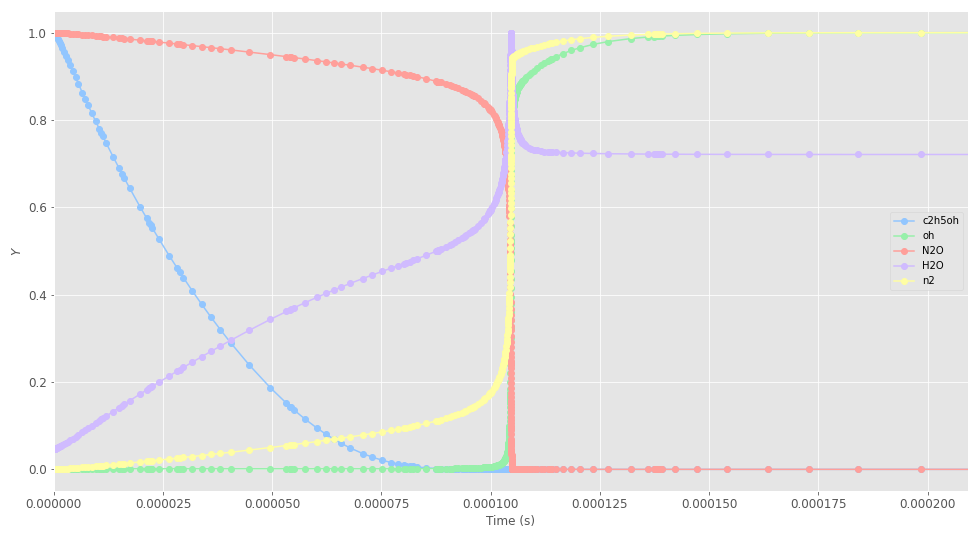

[]

In [162]:
plt.figure(figsize=(12,6))
plt.plot(timeHistory.index, timeHistory['c2h5oh']/timeHistory['c2h5oh'].max(),'-o', label='c2h5oh')
plt.plot(timeHistory.index, timeHistory['oh']/timeHistory['oh'].max(),'-o', label='oh')
plt.plot(timeHistory.index, timeHistory['N2O']/timeHistory['N2O'].max(),'-o', label='N2O')
plt.plot(timeHistory.index, timeHistory['h2o']/timeHistory['h2o'].max(),'-o', label='H2O')
plt.plot(timeHistory.index, timeHistory['n2']/timeHistory['n2'].max(),'-o', label='n2')
plt.xlabel('Time (s)')
plt.ylabel('$Y$')
plt.xlim([0,2*tau])
plt.legend()
plt.plot()

<IPython.core.display.Javascript object>


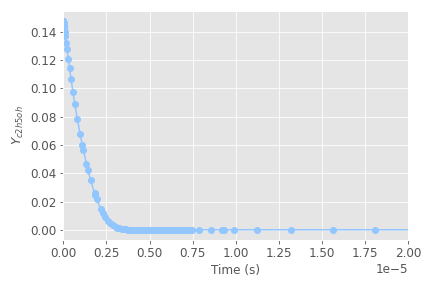

<IPython.core.display.Javascript object>


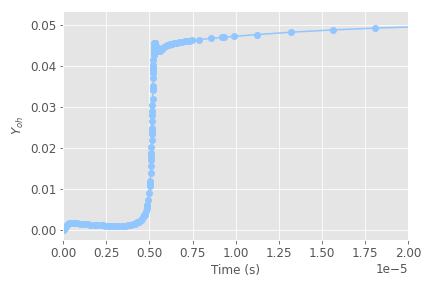

<IPython.core.display.Javascript object>


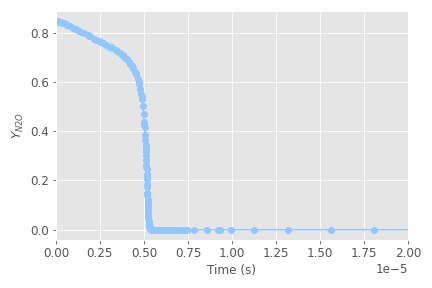

(0.0, 2e-05)

In [94]:
plt.figure()
plt.plot(timeHistory.index, timeHistory['c2h5oh'],'-o')
plt.xlabel('Time (s)')
plt.ylabel('$Y_{c2h5oh}$')
plt.xlim([0,0.00002])

plt.figure()
plt.plot(timeHistory.index, timeHistory['oh'],'-o')
plt.xlabel('Time (s)')
plt.ylabel('$Y_{oh}$')
plt.xlim([0,0.00002])

plt.figure()
plt.plot(timeHistory.index, timeHistory['N2O'],'-o')
plt.xlabel('Time (s)')
plt.ylabel('$Y_{N2O}$')
plt.xlim([0,0.00002])
#plt.arrow(0, 0.008, tau, 0, width=0.0001, head_width=0.0005,
#          head_length=0.001, length_includes_head=True, color='r', shape='full')
#plt.annotate(r'$Ignition Delay: \tau_{ign}$', xy=(0,0), xytext=(0.01, 0.0082), fontsize=16);

In [60]:
timeHistory

,mass,volume,temperature,h2,h,ch4,ch3,ch2,ch,ch2o,...,N2O,HNO,CN,HCN,H2CN,HCNN,HCNO,HOCN,HNCO,NCO
4.342800e-12,0.26747,1.0,1999.998510,4.430906e-12,3.317769e-13,1.927506e-13,6.454367e-08,1.877348e-18,4.971770e-19,1.262395e-12,...,0.846000,4.329647e-24,3.313428e-40,1.240180e-27,7.897333e-29,2.744486e-34,2.309817e-36,1.266227e-40,6.803134e-36,2.848725e-34
7.901428e-11,0.26747,1.0,1999.972889,8.069000e-11,1.094727e-10,6.374426e-11,1.174162e-06,2.251475e-15,1.644027e-16,4.176324e-10,...,0.846000,3.305509e-19,4.775254e-33,1.115091e-22,7.099326e-24,2.357277e-29,2.505093e-29,4.333615e-33,7.378391e-29,2.786716e-28
1.980122e-10,0.26747,1.0,1999.932034,2.028651e-10,6.851135e-10,4.002206e-10,2.941825e-06,3.072634e-14,1.032036e-15,2.623603e-09,...,0.846000,1.289279e-17,1.169138e-30,4.660410e-21,2.966225e-22,9.222994e-28,6.039375e-27,1.087310e-30,1.778837e-26,2.624001e-26
3.480085e-10,0.26747,1.0,1999.880496,3.590943e-10,2.106951e-09,1.235811e-09,5.168826e-06,1.603274e-13,3.186128e-15,8.106980e-09,...,0.845999,1.231845e-16,3.673942e-29,4.825753e-20,3.070491e-21,8.845345e-27,1.905893e-25,3.426531e-29,5.613721e-25,4.394332e-25
6.511697e-10,0.26747,1.0,1999.776191,6.885624e-10,7.311796e-09,4.323865e-09,9.666032e-06,1.034212e-12,1.114392e-14,2.840514e-08,...,0.845999,1.516845e-15,1.806020e-27,6.855994e-19,4.360797e-20,1.097912e-25,9.472487e-24,1.674674e-27,2.790181e-23,1.013278e-23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2.460449e-04,0.26747,1.0,3491.259958,4.568465e-03,3.154418e-03,1.932969e-13,5.330861e-12,1.361690e-11,4.296616e-11,1.471341e-08,...,0.000004,6.860784e-06,1.323233e-08,7.083575e-08,1.338624e-12,7.930172e-15,8.239915e-12,2.056202e-09,1.008120e-07,7.935644e-08
3.976896e-04,0.26747,1.0,3491.259958,4.568465e-03,3.154418e-03,1.932969e-13,5.330861e-12,1.361690e-11,4.296616e-11,1.471341e-08,...,0.000004,6.860784e-06,1.323233e-08,7.083575e-08,1.338624e-12,7.930172e-15,8.239915e-12,2.056202e-09,1.008120e-07,7.935644e-08
8.188344e-04,0.26747,1.0,3491.259958,4.568465e-03,3.154418e-03,1.932969e-13,5.330861e-12,1.361690e-11,4.296616e-11,1.471341e-08,...,0.000004,6.860784e-06,1.323233e-08,7.083575e-08,1.338624e-12,7.930172e-15,8.239915e-12,2.056202e-09,1.008120e-07,7.935644e-08
1.673775e-03,0.26747,1.0,3491.259958,4.568465e-03,3.154418e-03,1.932969e-13,5.330861e-12,1.361690e-11,4.296616e-11,1.471341e-08,...,0.000004,6.860784e-06,1.323233e-08,7.083575e-08,1.338624e-12,7.930172e-15,8.239915e-12,2.056202e-09,1.008120e-07,7.935644e-08


## Illustration : NTC behavior

A common benchmark for a reaction mechanism is its ability to reproduce the **N**egative **T**emperature **C**oefficient behavior. Intuitively, as the temperature of an explosive mixture increases, it should ignite faster. But, under certain conditions, we observe the opposite. This is referred to as NTC behavior. Reproducing experimentally observed NTC behavior is thus an important test for any mechanism. We will do this now by computing and visualizing the ignition delay for a wide range of temperatures

### Define the temperatures for which we will run the simulations

In [153]:
# Make a list of all the temperatures we would like to run simulations at
T = np.arange(500, 3000, 50)

estimatedIgnitionDelayTimes = 1e6*np.ones(len(T))

# Make time adjustments for the highest and lowest temperatures. This we do empirically
# estimatedIgnitionDelayTimes[:6] = 6*[0.1]
# estimatedIgnitionDelayTimes[-2:] = 10
# estimatedIgnitionDelayTimes[-1] = 100

# Now create a dataFrame out of these
ignitionDelays2 = pd.DataFrame(data={'T': T})
ignitionDelays2['ignDelay'] = np.nan

Now, what we will do is simply run the code above the plots for each temperature.

In [157]:
for i, temperature in enumerate(T):
    # Setup the gas and reactor
    reactorTemperature = temperature
    reactorPressure = 101325.0
    gas.TP = reactorTemperature, reactorPressure
    gas.set_equivalence_ratio(phi=1.0, fuel={'c2h5oh':0.9, 'h2o':0.1}, oxidizer={'o2':1.0, 'n2':3.76})
    r = ct.IdealGasReactor(contents=gas, name='Batch Reactor')
    reactorNetwork = ct.ReactorNet([r])
    # reactorNetwork.set_max_time_step(1e-5)

    # Create and empty data frame
    timeHistory = pd.DataFrame(columns=timeHistory.columns)

    t0 = time.time()

    t = 0
    counter = 0
    while t < estimatedIgnitionDelayTimes[i]:
        t = reactorNetwork.step()
        if not counter % 20:
            timeHistory.loc[t] = r.get_state()
        counter += 1

    if timeHistory['c2h5oh'].iloc[-1]/timeHistory['c2h5oh'].iloc[0] > 0.9:
        print('No ignition at T =', temperature, '| Kept ratio:', timeHistory['c2h5oh'].iloc[-1]/timeHistory['c2h5oh'].iloc[-1])
    else:
        tau = ignitionDelay(timeHistory, 'oh')
        t1 = time.time()

        print('Computed Ignition Delay: {:.3e} seconds for T={}K. Took {:3.2f}s to compute'.format(tau, temperature, t1-t0))

        ignitionDelays2.at[i, 'ignDelay'] = tau

No ignition at T = 500 | Kept ratio: 1.0
Computed Ignition Delay: 5.819e+04 seconds for T=550K. Took 1.11s to compute
Computed Ignition Delay: 3.521e+03 seconds for T=600K. Took 1.01s to compute
Computed Ignition Delay: 3.349e+02 seconds for T=650K. Took 0.97s to compute
Computed Ignition Delay: 4.643e+01 seconds for T=700K. Took 0.91s to compute
Computed Ignition Delay: 8.698e+00 seconds for T=750K. Took 0.94s to compute
Computed Ignition Delay: 2.029e+00 seconds for T=800K. Took 0.83s to compute
Computed Ignition Delay: 5.663e-01 seconds for T=850K. Took 0.77s to compute
Computed Ignition Delay: 1.842e-01 seconds for T=900K. Took 0.74s to compute
Computed Ignition Delay: 6.786e-02 seconds for T=950K. Took 0.70s to compute
Computed Ignition Delay: 2.751e-02 seconds for T=1000K. Took 0.80s to compute
Computed Ignition Delay: 1.192e-02 seconds for T=1050K. Took 0.67s to compute
Computed Ignition Delay: 5.390e-03 seconds for T=1100K. Took 0.63s to compute
Computed Ignition Delay: 2.511e-

### Figure: ignition delay ($\tau$) vs. the inverse of temperature ($\frac{1000}{T}$). 

<IPython.core.display.Javascript object>


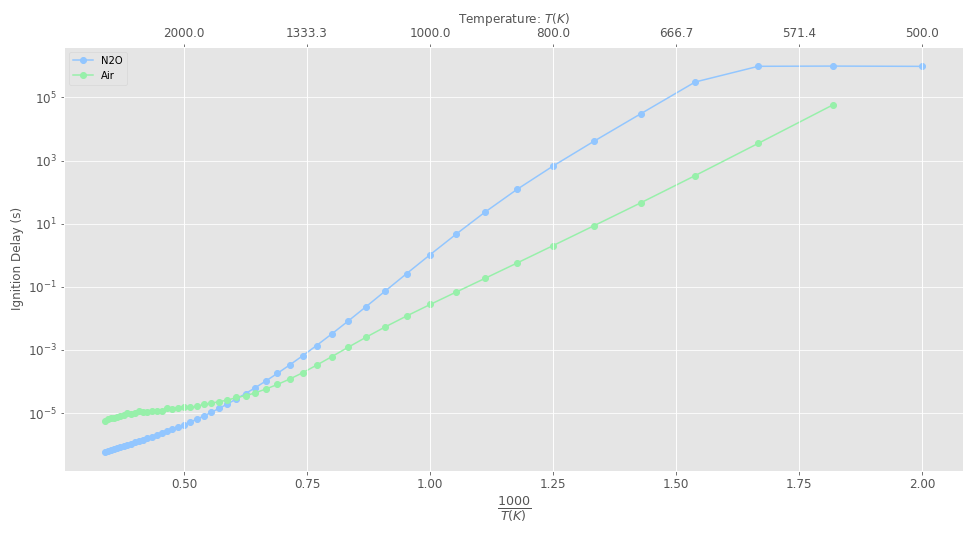

In [158]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.semilogy(1000/ignitionDelays['T'], ignitionDelays['ignDelay'], 'o-', label='N2O')
ax.semilogy(1000/ignitionDelays2['T'], ignitionDelays2['ignDelay'], 'o-', label='Air')
ax.set_ylabel('Ignition Delay (s)')
ax.set_xlabel(r'$\frac{1000}{T (K)}$', fontsize=18)
ax.legend()

# Add a second axis on top to plot the temperature for better readability
ax2 = ax.twiny()
ticks = ax.get_xticks()
ax2.set_xticks(ticks)
ax2.set_xticklabels((1000/ticks).round(1))
ax2.set_xlim(ax.get_xlim())
ax2.set_xlabel(r'Temperature: $T(K)$');

# Mechanism Reduction

<IPython.core.display.Javascript object>


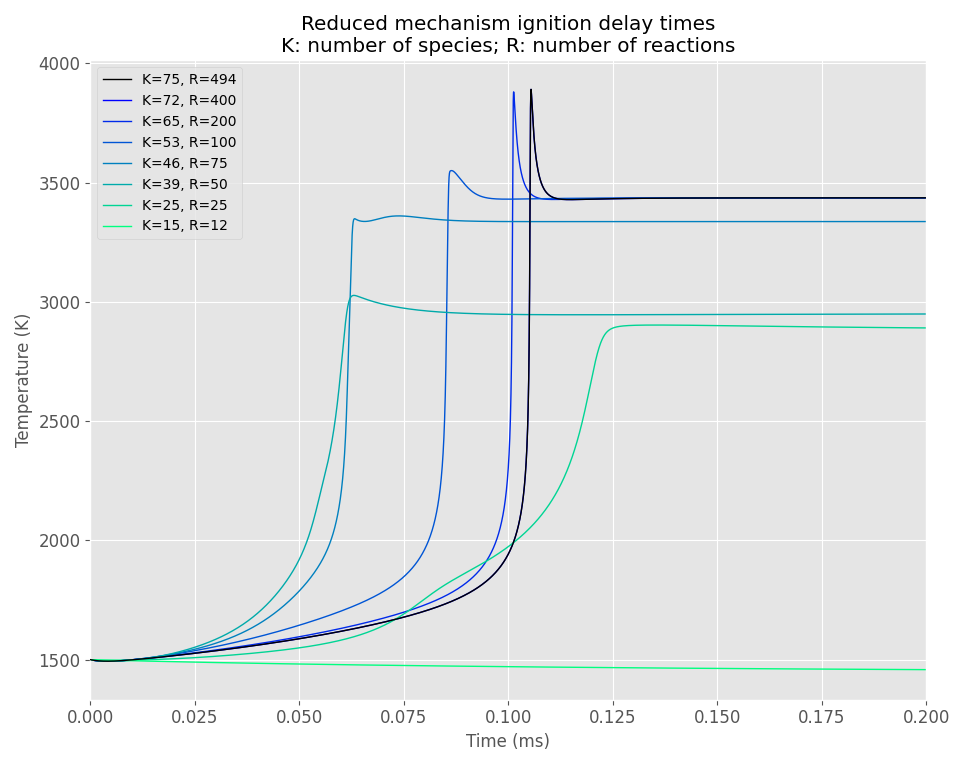

0
1
2
3
4
5
6


In [75]:
"""
A simplistic approach to mechanism reduction which demonstrates Cantera's
features for dynamically manipulating chemical mechanisms.

Here, we use the full GRI 3.0 mechanism to simulate adiabatic, constant pressure
ignition of a lean methane/air mixture. We track the maximum reaction rates for
each reaction to determine which reactions are the most important, according to
a simple metric based on the relative net reaction rate.

We then create a sequence of reduced mechanisms including only the top reactions
and the associated species, and run the simulations again with these mechanisms
to see whether the reduced mechanisms with a certain number of species are able
to adequately simulate the ignition delay problem.
"""
plt.figure()
gas = ct.Solution(
    thermo='IdealGas',
    kinetics='GasKinetics',
    species=complete_species,
    reactions=complete_reactions
)
# Define the reactor temperature and pressure
reactorTemperature = 1500 #Kelvin
reactorPressure = 101325.0 #Pascals
gas.TP = reactorTemperature, reactorPressure
# Define the fuel, oxidizer and set the stoichiometry
gas.set_equivalence_ratio(phi=1.0, fuel={'c2h5oh':1.0, 'h2o':0.0}, oxidizer={'N2O':1.0})

# Create a batch reactor object and add it to a reactor network
# In this example, the batch reactor will be the only reactor
# in the network
r = ct.IdealGasReactor(contents=gas, name='Batch Reactor')
reactorNetwork = ct.ReactorNet([r])

tt = []
TT = []
t = 0.0
# Rmax is the maximum relative reaction rate at any timestep
Rmax = np.zeros(gas.n_reactions)
while t < 1:
    t = reactorNetwork.step()
    tt.append(1000 * t)
    TT.append(r.T)
    rnet = abs(gas.net_rates_of_progress)
    rnet /= max(rnet)
    Rmax = np.maximum(Rmax, rnet)

plt.plot(tt, TT, label=f'K={len(complete_species)}, R={len(complete_reactions)}', color='k', lw=1, zorder=100)

# Get the reaction objects, and sort them so the most active reactions are first
R = sorted(zip(Rmax, gas.reactions()), key=lambda x: -x[0])

# Test reduced mechanisms with different numbers of reactions
C = plt.cm.winter(np.linspace(0,1,7))
for i, N in enumerate([400, 200, 100, 75, 50, 25, 12]):
    print(i)
    # Get the N most active reactions
    reactions = [r[1] for r in R[:N]]

    # find the species involved in these reactions. At a minimum, include all
    # species in the reactant mixture
    species_names = {'N2O', 'C2H5OH', 'H2O', 'N2', 'CO2', 'CO'}
    for reaction in reactions:
        species_names.update([name.upper() for name in reaction.reactants])
        species_names.update([name.upper() for name in reaction.products])

    # Get the species objects
    species = [gas.species(name) for name in species_names]

    # create the new reduced mechanism
    gas2 = ct.Solution(thermo='IdealGas', kinetics='GasKinetics',
                       species=species, reactions=reactions)
    
    # Re-run the ignition problem with the reduced mechanism
    reactorTemperature = 1500 #Kelvin
    reactorPressure = 101325.0 #Pascals
    gas2.set_equivalence_ratio(phi=1.0, fuel={'C2H5OH':1.0, 'H2O':0.0}, oxidizer={'N2O':1.0})
    gas2.TP = reactorTemperature, reactorPressure
    r = ct.IdealGasReactor(gas2)
    sim = ct.ReactorNet([r])

    t = 0.0

    tt = []
    TT = []
    while t < 0.02:
        t = sim.step()
        tt.append(1000 * t)
        TT.append(r.T)

    plt.plot(tt,TT, lw=1, color=C[i],
             label='K={0}, R={1}'.format(gas2.n_species, N))
    plt.xlabel('Time (ms)')
    plt.ylabel('Temperature (K)')
    plt.legend(loc='upper left')
    plt.title('Reduced mechanism ignition delay times\n'
              'K: number of species; R: number of reactions')
    plt.xlim(0, 0.2)
    plt.tight_layout()

plt.show()

<IPython.core.display.Javascript object>


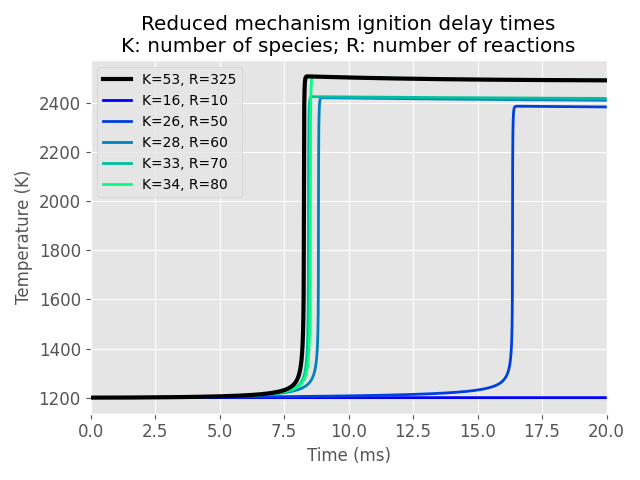

[<Species H2>, <Species O>, <Species N2>, <Species CH3>, <Species O2>, <Species CO2>, <Species NO>, <Species OH>, <Species CO>, <Species H>, <Species CH3O>, <Species HCO>, <Species HO2>, <Species N>, <Species H2O>, <Species CH4>]
[<ElementaryReaction: H + O2 <=> O + OH>, <ElementaryReaction: CH4 + OH <=> CH3 + H2O>, <ElementaryReaction: CO + OH <=> CO2 + H>, <ElementaryReaction: CH3 + HO2 <=> CH4 + O2>, <ElementaryReaction: N + NO <=> N2 + O>, <ElementaryReaction: 2 OH <=> H2O + O>, <ElementaryReaction: CH3 + HO2 <=> CH3O + OH>, <ElementaryReaction: HCO + O2 <=> CO + HO2>, <ElementaryReaction: HO2 + OH <=> H2O + O2>, <ElementaryReaction: H2 + OH <=> H + H2O>]


In [69]:
"""
A simplistic approach to mechanism reduction which demonstrates Cantera's
features for dynamically manipulating chemical mechanisms.

Here, we use the full GRI 3.0 mechanism to simulate adiabatic, constant pressure
ignition of a lean methane/air mixture. We track the maximum reaction rates for
each reaction to determine which reactions are the most important, according to
a simple metric based on the relative net reaction rate.

We then create a sequence of reduced mechanisms including only the top reactions
and the associated species, and run the simulations again with these mechanisms
to see whether the reduced mechanisms with a certain number of species are able
to adequately simulate the ignition delay problem.
"""

import cantera as ct
import numpy as np
import matplotlib.pyplot as plt
plt.figure()
gas = ct.Solution('gri30.xml')
initial_state = 1200, 5 * ct.one_atm, 'CH4:0.35, O2:1.0, N2:3.76'

# Run a simulation with the full mechanism
gas.TPX = initial_state
r = ct.IdealGasConstPressureReactor(gas)
sim = ct.ReactorNet([r])

tt = []
TT = []
t = 0.0
# Rmax is the maximum relative reaction rate at any timestep
Rmax = np.zeros(gas.n_reactions)
while t < 0.02:
    t = sim.step()
    tt.append(1000 * t)
    TT.append(r.T)
    rnet = abs(gas.net_rates_of_progress)
    rnet /= max(rnet)
    Rmax = np.maximum(Rmax, rnet)

plt.plot(tt, TT, label='K=53, R=325', color='k', lw=3, zorder=100)

# Get the reaction objects, and sort them so the most active reactions are first
R = sorted(zip(Rmax, gas.reactions()), key=lambda x: -x[0])

# Test reduced mechanisms with different numbers of reactions
C = plt.cm.winter(np.linspace(0,1,5))
for i,N in enumerate([10,50,60,70,80]):
    # Get the N most active reactions
    reactions = [r[1] for r in R[:N]]

    # find the species involved in these reactions. At a minimum, include all
    # species in the reactant mixture
    species_names = {'N2', 'CH4', 'O2'}
    for reaction in reactions:
        species_names.update(reaction.reactants)
        species_names.update(reaction.products)

    # Get the species objects
    species = [gas.species(name) for name in species_names]

    # create the new reduced mechanism
    gas2 = ct.Solution(thermo='IdealGas', kinetics='GasKinetics',
                       species=species, reactions=reactions)

    # Re-run the ignition problem with the reduced mechanism
    gas2.TPX = initial_state
    r = ct.IdealGasConstPressureReactor(gas2)
    sim = ct.ReactorNet([r])

    t = 0.0

    tt = []
    TT = []
    while t < 0.02:
        t = sim.step()
        tt.append(1000 * t)
        TT.append(r.T)

    plt.plot(tt,TT, lw=2, color=C[i],
             label='K={0}, R={1}'.format(gas2.n_species, N))
    plt.xlabel('Time (ms)')
    plt.ylabel('Temperature (K)')
    plt.legend(loc='upper left')
    plt.title('Reduced mechanism ignition delay times\n'
              'K: number of species; R: number of reactions')
    plt.xlim(0, 20)
    plt.tight_layout()
    
    if i == 0:
        print(species)
        print(reactions)

plt.show()

In [77]:
"""
Viewing a reaction path diagram.

This script uses Graphviz to generate an image. You must have Graphviz installed
and the program 'dot' must be on your path for this example to work.
Graphviz can be obtained from http://www.graphviz.org/ or (possibly) installed
using your operating system's package manager.
"""

import os
import sys

import cantera as ct

# these lines can be replaced by any commands that generate
# an object of a class derived from class Kinetics in some state.
gas = ct.Solution('gri30.xml')
gas.TPX = 1300.0, ct.one_atm, 'CH4:0.4, O2:1, N2:3.76'
r = ct.IdealGasReactor(gas)
net = ct.ReactorNet([r])
T = r.T
while T < 1900:
    net.step()
    T = r.T

element = 'N'

diagram = ct.ReactionPathDiagram(gas, element)
diagram.title = 'Reaction path diagram following {0}'.format(element)
diagram.label_threshold = 0.01

print(diagram.get_data())
dot_file = 'rxnpath.dot'
img_file = 'rxnpath.png'
img_path = os.path.join(os.getcwd(), img_file)

diagram.write_dot(dot_file)


print("Wrote graphviz input file to '{0}'.".format(os.path.join(os.getcwd(), dot_file)))

os.system('dot {0} -Tpng -o{1} -Gdpi=200'.format(dot_file, img_file))
print("Wrote graphviz output file to '{0}'.".format(img_path))

if "-view" in sys.argv:
    import webbrowser
    webbrowser.open('file:///' + img_path)

Reaction path diagram following N
N N2 NO N2O NO2 NH HNO NH2 NNH CN NCO HCN HOCN HNCO H2CN HCNN HCNO NH3 
N N2 1.06719e-09 -0.000512786
N NO 0.000288545 -9.75411e-08
N N2O 0 -0
N NO2 0 -0
N NH 3.89686e-06 -4.21106e-06
N HNO 0 -0
N NH2 0 -0
N NNH 0 -0
N CN 1.12694e-11 -1.46663e-07
N NCO 1.0639e-08 -1.93952e-08
N HCN 3.11376e-05 -4.74594e-16
N HOCN 0 -0
N HNCO 0 -0
N H2CN 0.000144022 -3.33791e-10
N HCNN 0 -0
N HCNO 0 -0
N NH3 0 -0
N2 NO 5.48357e-06 -1.03852e-09
N2 N2O 0.000143289 -3.63594e-05
N2 NO2 0 -0
N2 NH 9.03601e-08 -2.87631e-11
N2 HNO 0 -0
N2 NH2 0 -0
N2 NNH 0.0271805 -0.0271518
N2 CN 3.7336e-07 -1.25509e-12
N2 NCO 2.77949e-13 -1.42419e-11
N2 HCN 0.000506954 -9.67839e-12
N2 HOCN 0 -0
N2 HNCO 0 -0
N2 H2CN 6.52282e-08 -2.1095e-11
N2 HCNN 0.000447657 -0.000440805
N2 HCNO 0 -0
N2 NH3 0 -0
NO N2O 6.95744e-11 -2.85393e-06
NO NO2 4.38711e-06 -3.79184e-06
NO NH 1.13228e-11 -2.31911e-06
NO HNO 2.40822e-07 -6.31854e-06
NO NH2 0 -0
NO NNH 7.85817e-12 -5.97418e-06
NO CN 1.88629e-09 -3.41657e-

OSError: [Errno 22] Invalid argument: 'rxnpath.dot'